# Analysing Dataset

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

This notebook is dedicated to datasets analysis. 

Here we will concentrate on connecting our datasets into one dataframe that will later be used to extract meaningful information that can help us answer our research questions. 

In addition, data cleaning is performed where necessary since we will not use all the data provided. The goal of this notebook is to make data as easy as possible to use for future plotting and data story writing.

So, let's dive into our data!

In [3]:
import os
import re
import json
import time
import datetime
from functools import reduce
from itertools import product

from json import load, JSONDecodeError
from functional import pseq, seq
import pandas as pd
import pandas_profiling
import requests
import pathlib

# necessary to load the utils, which are in src
import sys
sys.path.append('../src')

from utils import file, logging
from utils.statement_handling import extract_information, safe_json_read

from importlib import reload

import utils.statement_handling as SH
reload(SH)

<module 'utils.statement_handling' from '../src/utils/statement_handling.py'>

In [4]:
def group_and_count(df, groupby_column, with_pct=False, with_avg=False):
    result = df.groupby(groupby_column).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
    if with_pct:
        result['count_pct'] = result['count'] / result['count'].sum()
    if with_avg:
        result['count_avg'] = result['count'].mean()
    return result

In [5]:
directory_liar_dataset = "../data/liar_dataset"
directory_statements = f"{directory_liar_dataset}/statements"
directory_visualizations = "../docs/data_insight"
directory_election_results = "../data/election_results"
directory_county_data = "../data/county_data"

# LIAR Dataset

This is just the LIAR dataset:

In [6]:
statements = seq(pathlib.Path(directory_statements).iterdir()).map(safe_json_read)\
                               .filter(lambda x: len(x) > 0)\
                               .map(extract_information)\
                               .to_pandas()

statements['statement_date'] = pd.to_datetime(statements['statement_date'])
statements.sample(10)

ERROR:root:File ../data/liar_dataset/statements/5355.json is empty or something...
ERROR:root:File ../data/liar_dataset/statements/9.json is empty or something...


,author_name_slug,context,label,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement,statement_date,statement_id,statement_type,statement_type_description,subject
3511,jacob-geiger,a House floor speech.,true,2011-03-05T08:00:24,"Minority leader, House of Delegates",Ward,Virginia,Armstrong,A telephone company will no longer have to pro...,2011-03-21,3366,Claim,blog post,Regulation
13094,joshua-gillin,a Florida House judiciary committee hearing,false,2015-04-06T17:45:22,"Sarasota state representative, District 73",Greg,Florida,Steube,You know how many children in the history of t...,2015-04-02,10685,Claim,blog post,Education
15304,tom-kertscher,a speech,half-true,2015-10-01T05:00:00,U.S. senator,Elizabeth,Massachusetts,Warren,Student loans from the federal government issu...,2015-09-26,11365,Claim,blog post,Debt
4914,louis-jacobson,the second presidential debate,mostly-true,2016-10-10T01:14:09,President,Donald,New York,Trump,We have an increase in murder within our citie...,2016-10-09,13234,Claim,blog post,Crime
9701,angie-drobnic-holan,a column,mostly-true,2009-06-24T09:57:25,New York Times columnist,Paul,,Krugman,Even high estimates for an early draft of the ...,2009-06-22,1060,Claim,blog post,Economy
10592,louis-jacobson,a campaign ad,barely-true,2014-02-14T11:47:17,,,,Patriot Majority USA,Says North Carolina Republican Senate candidat...,2014-02-12,8922,Claim,blog post,Federal Budget
8744,joshua-gillin,a headline,pants-fire,2017-04-06T10:00:00,,,,Bloggers,Police find 19 white female bodies in freezers...,2016-07-20,13955,Claim,blog post,Fake news
3083,katie-akin,a campaign ad from his political committee Flo...,barely-true,2018-07-27T16:09:43,Florida Commissioner of Agriculture,Adam,Florida,Putnam,Congressman (Ron) DeSantis sponsored legislati...,2018-07-24,15666,Claim,blog post,Taxes
7637,jon-greenberg,"a broadcast of ""Charlie Rose""",true,2015-02-25T16:41:01,,Michael,,Morell,The potential Iran nuclear agreement would lim...,2015-02-18,10550,Claim,blog post,Foreign Policy
6059,nell-benton,a statement on his campaign Web site.,mostly-true,2007-09-17T00:00:00,U.S. representative,Ron,Texas,Paul,Congressman Paul introduces numerous pieces of...,2007-09-17,70,Claim,blog post,Job Accomplishments


In [7]:
statements['speaker_last_name'].eq('Trump').sum()

646

In [8]:
print('The number of different context names is: {}.\
 That is much too many different contexts and lots of them appear only a few times.\
 We thus need to regroup/reduce the number of contexts.'.format(group_and_count(statements, 'context').shape[0]))

The number of different context names is: 5828. That is much too many different contexts and lots of them appear only a few times. We thus need to regroup/reduce the number of contexts.


In [9]:
group_and_count(statements, 'context').head(100)

,context,count
0,a tweet,471
1,an interview,380
2,a news release,329
3,a press release,325
4,a speech,319
5,a TV ad,275
6,a campaign ad,221
7,a headline,175
8,a television ad,168
9,,166


So how to regroup all these or part of these?
We can use the mean of communication for example:
radio/tv/facebook/twitter/internet
and these classes can have overlap...

In [10]:
statements['clean_context'] = statements['context'].apply(SH.clean_up_context)

In [11]:
# no longer necessary
if false:
    df['label_as_nb'] = df['label'].apply(label_to_nb) * 2 
    df['statement_id'] = pd.to_numeric(df['statement_id'])
    lies = df.merge(additional_information, on='statement_id', how='left')

NameError: name 'false' is not defined

Let's just see what we have here:

In [ ]:
# TODO rene add new values, see trello board
lies['label_to_nb'] = lies['label'].apply(label_to_nb) * 2

In [ ]:
lies['label'].value_counts()

In [ ]:
def _count_for_last_name_(df, last_name):
    return group_and_count(lies.loc[lies['speaker_last_name'].str.contains(last_name, flags=re.IGNORECASE), :], 'label', with_pct=True)\
            .rename(columns={'count': f'count_{last_name}', 'count_pct': f'count_pct{last_name}'})

In [ ]:
pd.merge(_count_for_last_name_(lies, 'obama'), _count_for_last_name_(lies, 'trump'), on='label')

Here we can see that Barack Obama had 549 statements labeled with _pants on fire_.

In [ ]:
lies[lies['speakers_job_title'].str.contains('County') == True].shape

In [ ]:
lies['statement_date'].describe()

Above, we can see that statements range from 1995 to 2016.

Now, let's do some profiling to get some more insights:

In [ ]:
pandas_profiling.ProfileReport(lies)

# Federal Election Results

We have another dataset that we will explore and merge to our LIAR dataset in order to get some more insight into data. This one is regarding election results.

In [ ]:
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 300

In [ ]:
from itertools import product
from functools import reduce

In [ ]:
def add_ending(f):
    """ File ending depending on a year
    
    Parameters
    ----------
    f: str
        Name of the file
    
    ToDos:
    - do 2012 it's a special snowflake
    """
    if '2016' in f:
        return f"{f}x"
    else:
        return f


election_files = [(add_ending(f'{directory_election_results}/federalelections{year}.xls'), year) for year in [2014, 2016]]

Now, let's prepare some data for viewing:

In [ ]:
election_results_cols_of_interest = ['CANDIDATE NAME', 'PRIMARY VOTES', 'PRIMARY %']

def fix_columns_election_results(df, year, type_):
    """we are only interested in the primary votes, since these reflect the opinion the most"""
    df = df.loc[:, election_results_cols_of_interest]
    df[f'primary_votes_{type_.lower()}_{year}'] = df['PRIMARY VOTES']
    df[f'primary_votes_{type_.lower()}_{year}_pct'] = df['PRIMARY %']
    return df.drop(columns=['PRIMARY VOTES', 'PRIMARY %'])


def get_only_voting_results(df):
    return df.loc[df['CANDIDATE NAME'].notna() & df['PRIMARY VOTES'].notna() & df['CANDIDATE NAME'].ne('Scattered') & df['CANDIDATE NAME'].ne('All Others'), :]


def prep_election_results(df, year, type_):
    return fix_columns_election_results(get_only_voting_results(df), year, type_)

In [12]:
election_results = [prep_election_results(pd.read_excel(f, sheet_name=f'{year} US {type_} Results by State'), year, type_) for (f, year), type_ in product(election_files, ['Senate', 'House'])]

# we let the results as they are, merge, and then check if the person is a senator or a member of the house based on the other results
# yes they did a spelling mistake
election_results += [prep_election_results(pd.read_excel(f'{directory_election_results}/federalelections2012.xls', sheet_name=f'2012 US House & Senate Resuts'), 2012, 'all')]
election_results = reduce(lambda acc, el: pd.merge(acc, el, on='CANDIDATE NAME', how='outer'), election_results)

NameError: name 'election_files' is not defined

In [13]:
election_results.head()

NameError: name 'election_results' is not defined

In [14]:
idx_multiple_election_results = election_results.loc[:, [c for c in election_results.columns if any((c.endswith(str(y)) for y in [2012, 2014, 2016]))]].notna().sum(axis=1) > 1

print(f"we have multple election results for {idx_multiple_election_results.sum()} politicians ({idx_multiple_election_results.mean()}%)")

NameError: name 'election_results' is not defined

In [15]:
election_results[idx_multiple_election_results].head()

NameError: name 'election_results' is not defined

In [16]:
# yeah ... let's see how many we can join. the one letter endings might be a problem
election_results['CANDIDATE NAME'].value_counts()

NameError: name 'election_results' is not defined

In [17]:
# we are only interest in people and they have a first name
lies = lies.loc[lies['speaker_first_name'].notnull(), :]

NameError: name 'lies' is not defined

In [18]:
# to aggregate the statements
lies['statement_year'] = lies['statement_date'].dt.year

# for the merging
lies['speaker_full_name'] = lies['speaker_last_name'] + ', ' + lies['speaker_first_name']

NameError: name 'lies' is not defined

### Cleaning job titles

In [19]:
# todo expand this and check this! this is just a quick and dirty fix
# is it really houseman? probably not...
_job_titles_of_interest = [('senat', 'senator'), ('governor', None), ('congress', 'congressman'), ('mayor', None), ('president', None), ('house', 'houseman'), ('rep', 'houseman')]
job_titles_of_interest = [out if out is not None else j for j, out in _job_titles_of_interest]

def cleaned_job_title(jt):
    jt = str(jt).lower()
    
    for j, out in _job_titles_of_interest:
        if j in jt:
            return out if out is not None else j
    else:
        return jt

lies['speakers_job_title_cleaned'] = lies['speakers_job_title'].apply(cleaned_job_title)

NameError: name 'lies' is not defined

In [20]:
_t = lies.merge(election_results, left_on='speaker_full_name', right_on='CANDIDATE NAME', how='outer')

NameError: name 'lies' is not defined

In [21]:
print(f"found election results for {_t['CANDIDATE NAME'].notnull().sum()} ({_t['CANDIDATE NAME'].notnull().mean()}%) people")

NameError: name '_t' is not defined

In [22]:
votes_cols = [c for c in _t.columns if 'votes' in c]
useful_idx = reduce(lambda acc, el: acc | el, [_t[c].notnull() for c in votes_cols]) & _t['speaker'].notnull() 

print(f"found useful results for {useful_idx.sum()} people")

columns_of_interest = ['label', 'label_as_nb', 'subject', 'speaker', 'speakers_job_title_cleaned', 'state_info', 'party_affiliation', 'context', 'statement_date'] + votes_cols
_t.loc[useful_idx, columns_of_interest]

NameError: name '_t' is not defined

In [23]:
_t.loc[useful_idx, 'speakers_job_title_cleaned'].value_counts()

NameError: name '_t' is not defined

In [24]:
_t.loc[_t['speakers_job_title_cleaned'].isin(job_titles_of_interest) & useful_idx, columns_of_interest]

NameError: name '_t' is not defined

Now, our dataframe looks like this:

In [25]:
_t.head(1)

NameError: name '_t' is not defined

# County Data

In [26]:
# load data file
county_raw = pd.read_csv(f"{directory_county_data}/acs2015_county_data.csv")
US_states = county_raw['State'].unique()
county_raw.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


# DATA SET COMPLETE

At this point, we collected all the columns we need. Let's see how we can clean them:

In [27]:
median_speaker_value = _t.groupby(['statement_year', 'speaker'])['label_as_nb'].median().reset_index()

NameError: name '_t' is not defined

In [28]:
median_speaker_value[median_speaker_value['statement_year'] == 2016]

NameError: name 'median_speaker_value' is not defined

### Non-People Speakers Handling

Removing non-people (_tweets, facebook posts, etc._) from the dataset:

In [29]:
from nltk import download
download('punkt')
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from collections import Counter

model = 'nlp/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = 'nlp/stanford-ner-2018-10-16/stanford-ner-3.9.2.jar'
st = StanfordNERTagger(model, jar, encoding='utf-8')

def get_tag(speaker):
    ner_tag = 0
    if type(speaker) == str:
        full_speaker_name = speaker.replace("-", " ").title()

        for sent in sent_tokenize(full_speaker_name):
            tokens = word_tokenize(sent)
            tags = st.tag(tokens)
            
        ner_tag= Counter(dict(tags).values()).most_common(1)[0][0]
        print(tags, " --> ", ner_tag)
    return ner_tag
    

# just to see if/how it works
word = "Twitter-Post-Anna"
get_ner_tag(word)

full_speaker_name = "Barack-Obama"
get_ner_tag(full_speaker_name)

full_speaker_name = 0
get_ner_tag(full_speaker_name)


[nltk_data] Downloading package punkt to /Users/puma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NameError: name 'get_ner_tag' is not defined

In [ ]:
import os.path

file_path = 'nlp/speaker_tags.json'

if not os.path.exists(file_path):
    print(f"Total number of values to classify: {len(_t['speaker'].value_counts().index)}")

    words_with_tags = {}
    for word in _t['speaker'].value_counts().index:
        words_with_tags[word] = get_tag(word)
    
    # save tags, since it took ~3h to tag all 3214 unique speakers
    with open(file_path, 'w') as fp:
        json.dump(words_with_tags, fp, indent=4)
else:
    with open(file_path, 'r') as f:
        words_with_tags = json.load(f)
    print(f"Total number of classified values (from file): {len(words_with_tags)}")

In [ ]:
_t["speaker_tag"] = _t.apply(lambda row: words_with_tags[row['speaker']] if not pd.isnull(row['speaker']) else row['speaker'], axis=1)
_t[['speaker','speaker_tag']].drop_duplicates()

Seems good, so now let's remove non-people from the dataset:

In [ ]:
_t.shape

In [ ]:
_t[_t['speaker_tag'] == "PERSON"].shape

We see that we will remove ~5000 statements which are made by (speaker) _Twitter, Facebook, Blog post, Republican Party Texas, etc._

In [30]:
# removing non-people statements
_t = _t[_t['speaker_tag'] == "PERSON"]

NameError: name '_t' is not defined

### Clean-up Context

In [31]:
_t["context"].value_counts().index.values

NameError: name '_t' is not defined

It would be good to try using the tool that would extract keywords from these phases. Let's use NLTK Rake:

In [32]:
from rake_nltk import Rake, Metric
from collections import Counter

debug = False

def do_keyword_extraction(words):
    if debug: print("---\n", words)
        
    rake_all = Rake()
    rake_all.extract_keywords_from_sentences(_t["context"].value_counts().index.values)

    word_degrees = dict(rake_all.get_word_degrees())
    
    r = Rake()
    r.extract_keywords_from_text(words)

    keywords = dict(r.get_word_degrees())
    
    if debug: print(keywords)
        
    for k, v in keywords.items():
        keywords[k] = word_degrees[k]
    
    if debug: print(keywords)

    return Counter(keywords).most_common(1)[0]

ModuleNotFoundError: No module named 'rake_nltk'

In [33]:
# try to see how it works
text_to_process = "a television interview"
do_keyword_extraction("an interview")
do_keyword_extraction("a television interview")
do_keyword_extraction("a TV interview")

NameError: name 'do_keyword_extraction' is not defined

In [34]:
_t["context_tag"] = _t.apply(lambda row: do_keyword_extraction(row['context']) if not pd.isnull(row['context']) else row['context'], axis=1)

NameError: name '_t' is not defined

In [35]:
context_tags = _t[['context','context_tag']]['context_tag'].value_counts()
print(f"Number of different context tags is {len(context_tags)}")
context_tags

NameError: name '_t' is not defined

We see that the number of context tags is 271, which is a preatty big number. Let's consider decreasing this number and make smaller groups.

In [36]:
# TODO: make smaller context groups, ideally around 10

In [37]:
# TODO: implement tagging on the cleaned jobs as well

In [38]:
# TODO: plot the answers from research questions we have

## Some initial insights

In [39]:
_t['sum_not_so_true'] = _t['pants_on_fire_counts']/(_t['barely_true_counts'] + _t['false_counts'] + _t['half_true_counts'] + _t['mostly_true_counts'] + _t['pants_on_fire_counts'])
number_of_party_affiliation = _t.groupby('party_affiliation')['sum_not_so_true'].sum().sort_values(ascending=False)
number_of_party_affiliation

NameError: name '_t' is not defined

Here are the `party_affiliations` who most lie ordered by their proportion of lies. But we already know that the 2 dominant parties in USA are republican and democrat. We see that there are lots of unknown party affiliations from which we can make identify 2 possibilities

In [40]:
number_of_party_affiliation = _t.groupby(['speaker'])['sum_not_so_true'].sum().sort_values(ascending=False)
number_of_party_affiliation.head(10)

NameError: name '_t' is not defined

Looking at the dataset content, people above are sorted quantity of lies.

In [41]:
all_contexts = _t['context_tag'].unique()
nb_elements_context = _t.groupby(['context_tag'])['context_tag'].count().sort_values(ascending=False)
nb_elements_context.head(50)

NameError: name '_t' is not defined

Looking at the context, it seems that people lie the most during the interviews, then speech, after debates, and so on...

## [misc] One statement content visualization

Let's analyse first row, statement with id `1`. What is the information we get there?

In [42]:
sid = 1.0

In [43]:
_t[_t.statement_id == sid]

NameError: name '_t' is not defined

In [44]:
with open(f"{directory_statements}/{int(sid)}.json", "r") as f:
    data = json.load(f)

Just to visualize JSON hierarchy, run the following cell:

In [45]:
def go_further(dic, name):
    dict_vis = {"name": name, "children": []}
    for k, v in dic.items():
        if type(v) == str:
            new_el = {"name": k}
        elif type(v) == list:
            if len(v) > 0:
                new_el = go_further(v[0], k)
        elif type(v) == dict:
            new_el = go_further(v, k)
        else:
            new_el = {"name": k}
        dict_vis["children"].append(new_el)
        
    return dict_vis

my_dict = go_further(data, name="statement_info")

with open(f"{directory_visualizations}/data.json", "w") as f:
    json.dump(my_dict, f)

print(f"Checkout visualization by: \n1) cd ../visualizations \n2) python -m http.server \n3) in browser, open: http://localhost:8000/")

FileNotFoundError: [Errno 2] No such file or directory: '../docs/data_insight/data.json'

## Biggest liars pants on fire

Here are the people who most lie ordered by their proportion of pants on fire.

In [46]:
people_pants_classification = statements[['speaker_first_name', 'speaker_last_name', 'label', 'speaker_home_state']]
#people_pants_classification[(people_pants_classification['speaker_first_name'].isnull() | people_pants_classification['speaker_first_name'].str.strip().eq('')) == False][:1].values

# We want to keep only people which have both a first-name and a last-name (not totaly perfect)
people_pants_classification = people_pants_classification[((people_pants_classification['speaker_first_name'].isnull() |
                                                           people_pants_classification['speaker_first_name'].str.strip().eq('')) == False)]
people_pants_classification = people_pants_classification[((people_pants_classification['speaker_last_name'].isnull() |
                                                           people_pants_classification['speaker_last_name'].str.strip().eq('')) == False)]
people_pants_classification = people_pants_classification[((people_pants_classification['label'].isnull() |
                                                           people_pants_classification['label'].str.strip().eq('')) == False)]

_blop = people_pants_classification[['speaker_first_name', 'speaker_last_name']].groupby(['speaker_first_name', 'speaker_last_name']).size().reset_index()
_blopblop = people_pants_classification.groupby(['speaker_first_name', 'speaker_last_name', 'label']).size().reset_index().rename(columns={'0':'nb_labeled_statements'})

statement_percentage = pd.merge(_blopblop,_blop,on=['speaker_first_name', 'speaker_last_name'])

statement_percentage['statements_perc'] = statement_percentage['0_x']/statement_percentage['0_y']
#statement_percentage.sample(5)

#### Pants on fire analysis

In [47]:
statement_percentage_cleaned = statement_percentage.loc[statement_percentage['label']=='pants-fire'].sort_values(by='statements_perc', ascending=False)

#### We need people who have at least a certain number of statements to limit bias

In [48]:
statement_percentage_cleaned_numerous = statement_percentage_cleaned.loc[statement_percentage_cleaned['0_y']>20]
print('The 10 badest guys with the highest percentage of pants on fire are:')
statement_percentage_cleaned_numerous.head(10)

The 10 badest guys with the highest percentage of pants on fire are:


,speaker_first_name,speaker_last_name,label,0_x,0_y,statements_perc
3746,Michele,Bachmann,pants-fire,16,61,0.262295
4668,Rush,Limbaugh,pants-fire,10,39,0.256410
2840,Josh,Mandel,pants-fire,6,29,0.206897
1824,Glenn,Beck,pants-fire,6,31,0.193548
1079,Dan,Patrick,pants-fire,6,32,0.187500
637,Bruce,Rauner,pants-fire,4,23,0.173913
116,Allen,West,pants-fire,4,26,0.153846
1395,Donald,Trump,pants-fire,92,639,0.143975
340,Ben,Carson,pants-fire,4,28,0.142857
3970,Newt,Gingrich,pants-fire,12,86,0.139535


In [49]:
statement_percentage_cleaned = statement_percentage_cleaned.loc[statement_percentage_cleaned['0_y']>1]
statement_percentage_cleaned.head(10)

,speaker_first_name,speaker_last_name,label,0_x,0_y,statements_perc
3625,Matthew,Rosendale,pants-fire,2,2,1.0
2939,Kathie,Glass,pants-fire,2,2,1.0
1850,Graeme,Zielinski,pants-fire,2,2,1.0
2847,Joshua,Feuerstein,pants-fire,2,2,1.0
5022,Steve,Kagen,pants-fire,2,2,1.0
5441,Uspoln,Website,pants-fire,4,4,1.0
1064,Dan,Kapanke,pants-fire,2,2,1.0
1039,Daily World,Update,pants-fire,4,4,1.0
641,Bryan,Fischer,pants-fire,2,2,1.0
363,Betsy,McCaughey,pants-fire,2,2,1.0


In [50]:
%matplotlib inline
#statement_percentage_cleaned.plot(kind='scatter' y='statements_perc')
import seaborn as sns

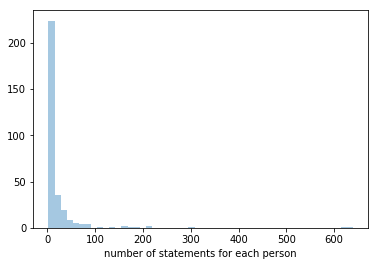

In [51]:
sns.distplot(statement_percentage_cleaned['0_y'], bins=50, kde=False, axlabel='number of statements for each person')

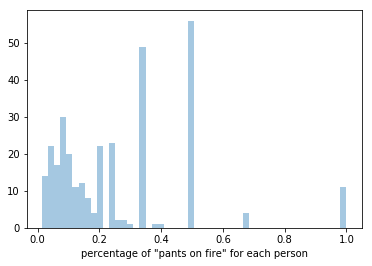

In [52]:
sns.distplot(statement_percentage_cleaned.statements_perc, bins=50, kde=False, axlabel='percentage of "pants on fire" for each person')

In [67]:
statement_percentage_cleaned_top10 = statement_percentage_cleaned.sort_values(['0_y'], ascending=[False]).head(10).sort_values(['statements_perc'], ascending=[False])
statement_percentage_cleaned_top10

,speaker_first_name,speaker_last_name,label,0_x,0_y,statements_perc
1395,Donald,Trump,pants-fire,92,639,0.143975
4428,Rick,Perry,pants-fire,18,175,0.102857
3904,Mitt,Romney,pants-fire,19,216,0.087963
5149,Ted,Cruz,pants-fire,9,141,0.063830
4817,Scott,Walker,pants-fire,11,211,0.052133
4443,Rick,Scott,pants-fire,8,164,0.048780
2662,John,McCain,pants-fire,8,190,0.042105
3422,Marco,Rubio,pants-fire,5,163,0.030675
1973,Hillary,Clinton,pants-fire,7,300,0.023333
287,Barack,Obama,pants-fire,9,619,0.014540


In [53]:
# Column renaming does not work
#.rename(columns={'0':'nb_statements'})
# to rename the column of counts df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
# _blop.rename(columns='0':'nb_statements')

In [54]:
# Verification, not needed
_blop[_blop['speaker_last_name'].eq('Trump')]

,speaker_first_name,speaker_last_name,0
774,Donald,Trump,639
1114,Ivanka,Trump,7


## Blopy objects

In [58]:
safe_json_read(list(pathlib.Path(directory_statements).iterdir())[0])

{'art': [{'brightcove': '',
   'caption': 'Texas Sen. Steve Ogden, R-Bryan, and Republican Lt. Gov. David Dewhurst spoke to reporters April 5 about the state budget and the tax system.',
   'id': 1257,
   'infogram': '',
   'ndn': '',
   'ndnid': '',
   'other': '',
   'photo': None,
   'resource_type': {'id': 2,
    'name': 'YouTube',
    'resource_uri': '/api/v/2/mediatype/2/'},
   'resource_uri': '/api/v/2/media/1257/',
   'title': 'Steve Ogden, business tax',
   'wibbitz': '',
   'youtube': '<iframe src="//www.youtube.com/embed/EaRdqdEUrZQ?rel=0&wmode=opaque" frameborder="0" allowfullscreen></iframe>',
   'youtubeID': 'EaRdqdEUrZQ'}],
 'author': [{'email_address': 'mashford-grooms@statesman.com',
   'first_name': 'Meghan',
   'id': 118,
   'last_name': 'Ashford-Grooms',
   'name_slug': 'meghan-ashford-grooms',
   'on_staff_page': None,
   'phone': None,
   'photo': None,
   'publication': {'id': 3,
    'publication_name': 'Austin American-Statesman',
    'resource_uri': '/api/v/2/p

In [59]:
res.get('subject', {'description':''}).get('description','')

NameError: name 'res' is not defined

In [85]:
subject_toward_simplification = group_and_count(statements, 'subject', with_pct=True)
subject_toward_simplification.head(140)

,subject,count,count_pct
0,Economy,1244,0.080409
1,Health Care,1114,0.072006
2,Candidate Biography,819,0.052938
3,Education,813,0.052550
4,Elections,660,0.042660
5,Crime,570,0.036843
6,Federal Budget,529,0.034193
7,Immigration,477,0.030832
8,Taxes,473,0.030573
9,Foreign Policy,446,0.028828


In [88]:
def clean_up_subject(c):
    # Insensitive case search of terms to regroup similar subjects together
    # normally this would have been done with a regex, but since the dataset is small enough this works well
    
    c = c.lower()
    
    if any([s in c for s in ['budget', 'deficit', 'debt', 'economy', 'finance', 'taxe', 'income', 'trade', 'pension', 'retirement', 'gas', 'price']]):
        return 'economy'
    elif any([s in c for s in ['health care', 'water' 'aid', 'medic', 'alcohol', 'welfare', 'disability', 'ebola', 'food']]):
        return 'health'
    elif any([s in c for s in ['energy', 'climate', 'environment', 'transportation', 'agriculture', 'weather', 'natur', 'nuclear']]):
        return 'environment'
    elif any([s in c for s in ['immigration', 'foreign']]):
        return 'immigration'
    elif any([s in c for s in ['fake', 'news', 'correction', 'update', 'ethics', 'public', 'administration', 'transparency']]):
        return 'fake'
    elif any([s in c for s in ['abortion', 'children', 'education', 'gay', 'sex', 'privacy', 'recreation', 'tourism']]):
        return 'family'
    elif any([s in c for s in ['corporation', 'job', 'civil', 'rights', 'ethics', 'labor', 'worker']]):
        return 'rights'
    elif any([s in c for s in ['gun', 'crim', 'justice', 'security', 'terrorism', 'military', 'afghanistan', 'iraq', 'drugs', 'safety', 'marijuana', 'penalty']]):
        return 'security'
    elif any([s in c for s in ['government', 'election', 'candidate', 'congress', 'history', 'parti']]):
        return 'politics'

    else:
        return 'other_subject'

In [92]:
statements['clean_subject'] = statements['subject'].apply(clean_up_subject)

In [96]:
group_and_count(statements,'clean_subject').head(100)


,clean_subject,count
0,economy,3474
1,politics,2366
2,security,1632
3,family,1527
4,other_subject,1493
5,health,1318
6,fake,1019
7,immigration,923
8,environment,916
9,rights,803
